In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
#from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [3]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
#from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
#from keras.utils import to_categorical

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [5]:
BASE_DIR = 'data_fil_Pro'
WORKING_DIR = 'working'

In [6]:
# Some urls are blocked from untrusted sites, the below code make python environment to trust every site
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
model1 =  ResNet50(weights="imagenet", input_shape=(224,224,3))

model = Model(model1.input, model1.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
# extract features from image
count = 0
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    if not img_name.startswith('.'):
    #print(img_name)
    # load the image from file
        img_path = directory + '/' + img_name
        image = load_img(img_path, target_size=(224,224))
        count = count+1
        #print(count)
        # convert image pixels to numpy array
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        # reshape data for model
        #image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # preprocess image for vgg
        image = preprocess_input(image)
        # extract features
        feature = model.predict(image, verbose=0)
        # get image ID
        image_id = img_name.split('.')[0]
        # store feature
        #features[image_id] = feature.reshape(2048)
        features[image_id] = feature

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1977 [00:00<?, ?it/s]

In [9]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features_res.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features_res.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/1978 [00:00<?, ?it/s]

In [10]:
len(mapping)

1977

In [11]:
import re
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from random import sample

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('.', '')
            caption = re.sub(r"[^a-zA-Z0-9 ]", "", caption)
            #caption = caption.replace('[^A-Za-z]', '')
            caption =''.join((x for x in caption if not x.isdigit()))
            caption = caption.replace('jmf','')
            caption = caption.replace('xmm','')
            caption = caption.replace('cmmm','')
            caption = caption.replace('xxl','')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            #caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>2]) + ' endseq'
            caption = " ".join([word for word in caption.split() if len(word)>2])
            word_tokens = word_tokenize(caption)
            caption = " ".join([w for w in word_tokens if not w.lower() in stop_words])
            #caption = " ".join(sample(caption.split(),min(2, len(caption.split()))))
            caption = caption.split()[random.randint(0, len(caption.split())-1)]
            #print(caption)
            caption = 'startseq ' + caption + ' endseq'
            print(caption)
            captions[i] = caption


In [12]:
# before preprocess of text 
mapping['0_180_12_4']

['Fossil petrified mammoth molar tooth  14.4 cm']

In [13]:
# preprocess the text
clean(mapping)

startseq skull endseq
startseq carved endseq
startseq tiger endseq
startseq large endseq
startseq mod endseq
startseq handbag endseq
startseq bag endseq
startseq birks endseq
startseq mod endseq
startseq caramel endseq
startseq leather endseq
startseq vintage endseq
startseq handbag endseq
startseq made endseq
startseq condition endseq
startseq lizard endseq
startseq lizard endseq
startseq natural endseq
startseq turtle endseq
startseq natural endseq
startseq natural endseq
startseq turtle endseq
startseq elephant endseq
startseq elephant endseq
startseq ivory endseq
startseq ivory endseq
startseq elephant endseq
startseq snakeskin endseq
startseq python endseq
startseq dragon endseq
startseq python endseq
startseq dragon endseq
startseq wallet endseq
startseq wallet endseq
startseq wallet endseq
startseq wallet endseq
startseq dragon endseq
startseq late endseq
startseq giant endseq
startseq trim endseq
startseq jacket endseq
startseq leather endseq
startseq trim endseq
startseq real 

startseq native endseq
startseq bear endseq
startseq leopardcheetah endseq
startseq thimble endseq
startseq organically endseq
startseq eggs endseq
startseq farm endseq
startseq highly endseq
startseq kyoto endseq
startseq netsuke endseq
startseq netsuke endseq
startseq kyoto endseq
startseq kyoto endseq
startseq ivory endseq
startseq netsuke endseq
startseq tiger endseq
startseq school endseq
startseq netsuke endseq
startseq tiger endseq
startseq ivory endseq
startseq school endseq
startseq netsuke endseq
startseq bone endseq
startseq shell endseq
startseq jizhou endseq
startseq chinese endseq
startseq glazed endseq
startseq brooch endseq
startseq shell endseq
startseq shell endseq
startseq shell endseq
startseq shell endseq
startseq shell endseq
startseq feet endseq
startseq rubies endseq
startseq fuzzybear endseq
startseq brown endseq
startseq feet endseq
startseq italian endseq
startseq size endseq
startseq dog endseq
startseq size endseq
startseq custom endseq
startseq collars end

startseq glass endseq
startseq taxidermy endseq
startseq taxidermy endseq
startseq ibis endseq
startseq ibis endseq
startseq ibis endseq
startseq ibis endseq
startseq taxidermy endseq
startseq taxidermy endseq
startseq ibis endseq
startseq spine endseq
startseq vertebrae endseq
startseq bracelet endseq
startseq king endseq
startseq snake endseq
startseq snake endseq
startseq spine endseq
startseq snake endseq
startseq taxidermy endseq
startseq snake endseq
startseq snake endseq
startseq vintage endseq
startseq cobra endseq
startseq british endseq
startseq edition endseq
startseq limited endseq
startseq connoisseur endseq
startseq british endseq
startseq antique endseq
startseq taxidermy endseq
startseq turtle endseq
startseq taxidermy endseq
startseq lizard endseq
startseq taxidermy endseq
startseq lizard endseq
startseq taxidermy endseq
startseq lizard endseq
startseq lizard endseq
startseq taxidermy endseq
startseq lizard endseq
startseq lizard endseq
startseq taxidermy endseq
starts

startseq alligator endseq
startseq alligator endseq
startseq genuine endseq
startseq italian endseq
startseq buckles endseq
startseq italian endseq
startseq couture endseq
startseq buckles endseq
startseq couture endseq
startseq buckles endseq
startseq belts endseq
startseq couture endseq
startseq couture endseq
startseq belts endseq
startseq couture endseq
startseq buckles endseq
startseq belts endseq
startseq leather endseq
startseq lot endseq
startseq purses endseq
startseq purses endseq
startseq purses endseq
startseq lot endseq
startseq purses endseq
startseq purses endseq
startseq lot endseq
startseq purses endseq
startseq purses endseq
startseq collectibles endseq
startseq crystals endseq
startseq collectibles endseq
startseq clear endseq
startseq bands endseq
startseq watch endseq
startseq real endseq
startseq collectibles endseq
startseq silver endseq
startseq lot endseq
startseq designer endseq
startseq cavalli endseq
startseq designer endseq
startseq leather endseq
startseq 

startseq pendant endseq
startseq stone endseq
startseq lapidary endseq
startseq stone endseq
startseq cabochon endseq
startseq lapidary endseq
startseq lapidary endseq
startseq lapidary endseq
startseq eye endseq
startseq specimen endseq
startseq tiger endseq
startseq tigers endseq
startseq bracelet endseq
startseq gold endseq
startseq eye endseq
startseq eye endseq
startseq bracelet endseq
startseq display endseq
startseq eye endseq
startseq tigers endseq
startseq lapidary endseq
startseq stone endseq
startseq lapidary endseq
startseq eye endseq
startseq tiger endseq
startseq lapidary endseq
startseq lapidary endseq
startseq tiger endseq
startseq polished endseq
startseq tiger endseq
startseq stone endseq
startseq stone endseq
startseq tiger endseq
startseq tiger endseq
startseq specimen endseq
startseq cabochon endseq
startseq cabochon endseq
startseq iron endseq
startseq lapidary endseq
startseq lapidary endseq
startseq lapidary endseq
startseq rock endseq
startseq lapidary endseq
s

In [14]:
# after preprocess of text
mapping['0_180_12_4']

['startseq petrified endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

1977

In [17]:
all_captions[:10]

['startseq skull endseq',
 'startseq carved endseq',
 'startseq tiger endseq',
 'startseq large endseq',
 'startseq mod endseq',
 'startseq handbag endseq',
 'startseq bag endseq',
 'startseq birks endseq',
 'startseq mod endseq',
 'startseq caramel endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

538

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

3

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [23]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(decoder1)
outputs = Dense(vocab_size, activation='softmax', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [24]:
# train the model
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=2)

epochs = 50
batch_size = 64
steps = len(train) // batch_size
val_steps = len(test) // batch_size
hist = model.fit(data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
                steps_per_epoch=steps, epochs=50,
                callbacks = [early_stopping_cb],
                validation_data=data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size),
                validation_steps=val_steps,
                 verbose=1)

Epoch 1/50
27/27 [==============================] - 8s 125ms/step - loss: 12.4992 - val_loss: 10.0889
Epoch 2/50
27/27 [==============================] - 2s 64ms/step - loss: 7.9386 - val_loss: 6.6531
Epoch 3/50
27/27 [==============================] - 2s 69ms/step - loss: 5.6464 - val_loss: 5.4175
Epoch 4/50
27/27 [==============================] - 2s 66ms/step - loss: 4.5704 - val_loss: 4.8586
Epoch 5/50
27/27 [==============================] - 2s 65ms/step - loss: 3.9556 - val_loss: 4.4889
Epoch 6/50
27/27 [==============================] - 2s 65ms/step - loss: 3.6144 - val_loss: 4.2397
Epoch 7/50
27/27 [==============================] - 2s 66ms/step - loss: 3.3774 - val_loss: 4.0543
Epoch 8/50
27/27 [==============================] - 2s 65ms/step - loss: 3.2136 - val_loss: 3.9944
Epoch 9/50
27/27 [==============================] - 2s 74ms/step - loss: 3.1514 - val_loss: 3.9198
Epoch 10/50
27/27 [==============================] - 2s 68ms/step - loss: 3.0287 - val_loss: 4.0315
Epoch 

In [28]:
"""# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)"""

'# train the model\nepochs = 20\nbatch_size = 32\nsteps = len(train) // batch_size\n\nfor i in range(epochs):\n    # create data generator\n    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)\n    # fit for one epoch\n    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)'

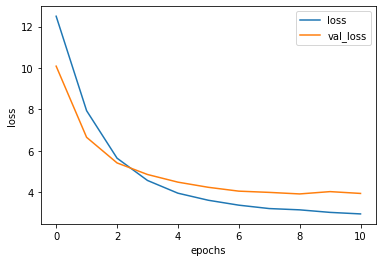

In [25]:
import matplotlib.pyplot as plt
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [30]:
# save the model
#model.save(WORKING_DIR+'/best_model_filter.h5')

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/198 [00:00<?, ?it/s]

BLEU-1: 0.670034
BLEU-2: 0.082268


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq purse endseq
--------------------Predicted--------------------
startseq snake endseq


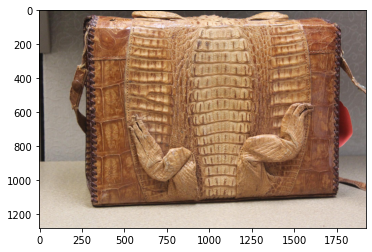

In [30]:
generate_caption("0_0_0_2.jpg")


---------------------Actual---------------------
startseq ivory endseq
--------------------Predicted--------------------
startseq carved endseq


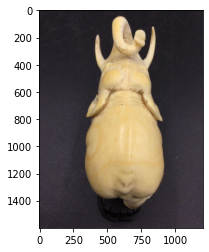

In [31]:
generate_caption("0_175_22_2.jpg")


---------------------Actual---------------------
startseq petrified endseq
--------------------Predicted--------------------
startseq matrix endseq


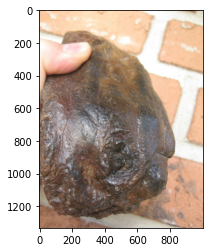

In [32]:
generate_caption("0_180_12_4.jpg")


---------------------Actual---------------------
startseq hyphalosaurus endseq
--------------------Predicted--------------------
startseq tooth endseq


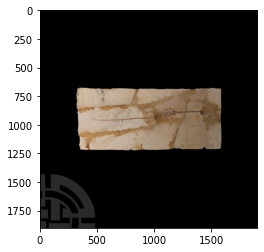

In [33]:
generate_caption("0_477_4_0.jpg")


---------------------Actual---------------------
startseq skull endseq
--------------------Predicted--------------------
startseq carved endseq


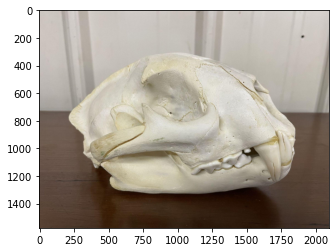

In [34]:
generate_caption("0_300_0_0.jpg")


---------------------Actual---------------------
startseq ottoman endseq
--------------------Predicted--------------------
startseq leopard endseq


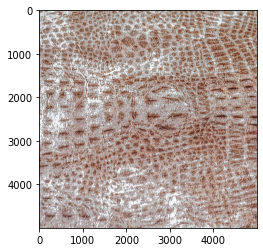

In [35]:
generate_caption("0_147_10_3.jpg")


---------------------Actual---------------------
startseq hartebeest endseq
--------------------Predicted--------------------
startseq taxidermy endseq


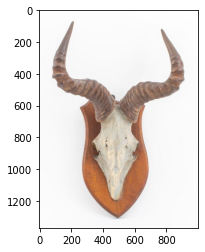

In [36]:
generate_caption("0_179_30_2.jpg")

---------------------Actual---------------------
startseq lizard endseq
--------------------Predicted--------------------
startseq taxidermy endseq


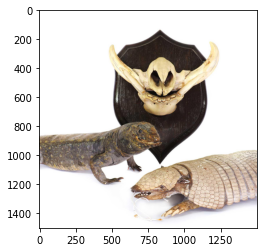

In [37]:
generate_caption("0_316_0_4.jpg")

In [38]:
test

['0_555_10_0',
 '0_555_10_1',
 '0_555_10_3',
 '0_555_10_2',
 '0_555_4_4',
 '0_555_4_5',
 '0_555_4_7',
 '0_555_4_6',
 '0_555_4_2',
 '0_555_4_3',
 '0_555_4_1',
 '0_555_4_0',
 '0_555_12_4',
 '0_555_12_5',
 '0_555_12_7',
 '0_555_12_6',
 '0_555_12_2',
 '0_555_12_3',
 '0_555_12_1',
 '0_555_12_0',
 '0_555_12_8',
 '0_555_12_9',
 '0_555_2_2',
 '0_555_2_3',
 '0_555_2_1',
 '0_555_2_0',
 '0_555_2_4',
 '0_154_6_5',
 '0_154_6_4',
 '0_154_6_0',
 '0_154_6_1',
 '0_154_6_3',
 '0_154_6_2',
 '0_154_2_2',
 '0_154_2_3',
 '0_154_2_1',
 '0_154_2_0',
 '11_161_0_0',
 '11_161_0_1',
 '11_161_0_3',
 '11_161_0_2',
 '11_161_0_5',
 '11_161_0_4',
 '11_161_4_4',
 '11_161_4_5',
 '11_161_4_6',
 '11_161_4_2',
 '11_161_4_3',
 '11_161_4_1',
 '11_161_4_0',
 '11_161_3_1',
 '11_161_3_0',
 '11_161_3_2',
 '11_161_2_2',
 '11_161_2_3',
 '11_161_2_1',
 '11_161_2_0',
 '11_161_2_4',
 '0_361_2_2',
 '0_361_2_3',
 '0_361_2_1',
 '0_361_2_0',
 '0_357_0_9',
 '0_357_0_8',
 '0_357_0_0',
 '0_357_0_11',
 '0_357_0_10',
 '0_357_0_1',
 '0_357_0_3

---------------------Actual---------------------
startseq large endseq
--------------------Predicted--------------------
startseq taxidermy endseq


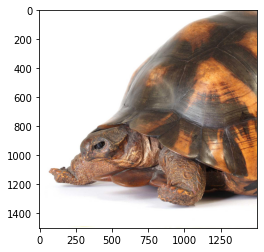

In [39]:
generate_caption("0_555_10_0.jpg")

---------------------Actual---------------------
startseq hand endseq
--------------------Predicted--------------------
startseq taxidermy endseq


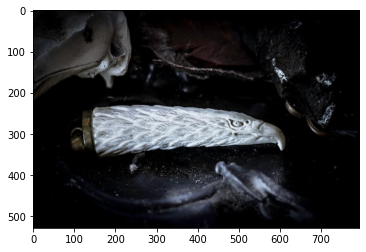

In [40]:
generate_caption("11_161_3_2.jpg")

---------------------Actual---------------------
startseq stone endseq
--------------------Predicted--------------------
startseq tooth endseq


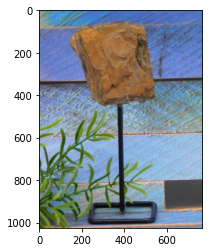

In [41]:
generate_caption("0_539_46_0.jpg")

---------------------Actual---------------------
startseq perched endseq
--------------------Predicted--------------------
startseq snake endseq


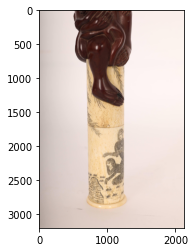

In [42]:
generate_caption("0_357_0_10.jpg")

---------------------Actual---------------------
startseq box endseq
--------------------Predicted--------------------
startseq two endseq


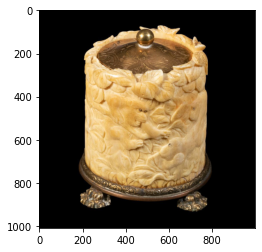

In [43]:
generate_caption("0_361_2_0.jpg")